<a href="https://colab.research.google.com/github/paruliansaragi/DL-Notebooks/blob/master/Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget http://pjreddie.com/media/files/cifar.tgz  


Redirecting output to ‘wget-log’.


Creating a model from scratch. Finding the mean, standard deviations etc.

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb

In [0]:
!mv cifar.tgz data

In [0]:
!tar zxvf cifar.tgz

In [0]:
!pip install fastai

In [0]:
from fastai.conv_learner import *
PATH = "cifar/"

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [0]:
for i in classes:
  os.makedirs('cifar/train/'+i,exist_ok=True)

In [0]:
for i in classes:
  os.makedirs('cifar/test/'+i,exist_ok=True)

In [0]:
import shutil

source = 'cifar/test/'
dest1 = 'cifar/test/plane'

files = os.listdir(source)


for f in files:
  if 'plane' not in f :
    continue
  else:
    shutil.move(source+f, dest1)

In [0]:
!find -type f -name '*automobile*' -delete

In [0]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [0]:
bs=256

In [0]:
data = get_data(32,4)


In [0]:
x,y=next(iter(data.trn_dl))


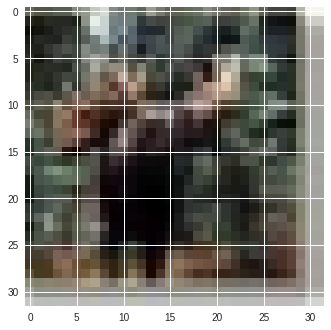

In [0]:
plt.imshow(data.trn_ds.denorm(x)[0]);


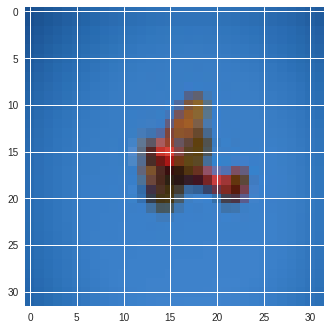

In [0]:
plt.imshow(data.trn_ds.denorm(x)[1]);


In [0]:
data = get_data(32,bs)


In [0]:
lr=1e-2


In [0]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)


In [0]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)


In [0]:
learn, [o.numel() for o in learn.model.parameters()]


(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40, bias=True)
     (1): Linear(in_features=40, out_features=10, bias=True)
   )
 ), [122880, 40, 400, 10])

In [0]:
learn.summary()


OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [0]:
learn.lr_find()


 76%|███████▌  | 133/176 [00:21<00:07,  6.14it/s, loss=8.72]

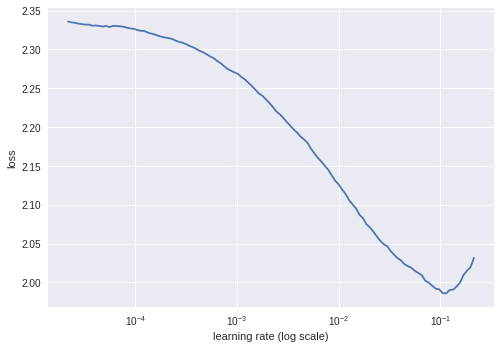

In [0]:
learn.sched.plot()

In [0]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy   
    0      1.682744   1.562661   0.432778  
    1      1.610785   1.517009   0.455889  
CPU times: user 1min 4s, sys: 33.9 s, total: 1min 38s
Wall time: 1min 5s


[array([1.51701]), 0.4558888889418708]

In [0]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [0]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)


In [0]:
learn.summary()


OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [0]:
learn.lr_find(end_lr=100)


 69%|██████▉   | 122/176 [00:20<00:11,  4.63it/s, loss=28.4]

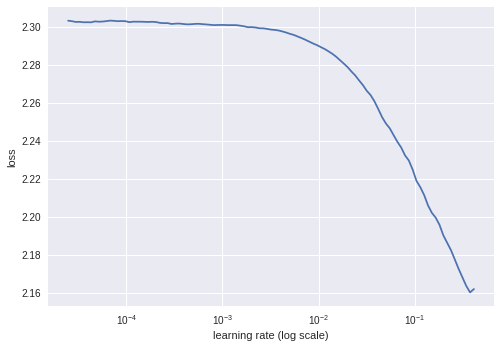

In [0]:
learn.sched.plot()


In [0]:
%time learn.fit(1e-1, 2)


epoch      trn_loss   val_loss   accuracy   
    0      1.696589   1.572525   0.421333  
    1      1.492112   1.418274   0.493111  
CPU times: user 1min 4s, sys: 33.5 s, total: 1min 38s
Wall time: 1min 5s


[array([1.41827]), 0.4931111112170749]

In [0]:
%time learn.fit(1e-1, 4, cycle_len=1)
